# **Import Library yang dibutuhkan**

In [2]:
# Mengimport Library yang dibutuhkan

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Import Library yang dibutuhkan

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# **Load Dataset**

In [3]:
# Load Dataset

df = pd.read_csv("/content/drive/MyDrive/Dataset Ulasan Google Play/scrapped_data_C_1.csv")
df.head()

,userName,score,at,content
0,Sandi Songgi,5,2024-07-31 07:16:13,mantap sob
1,Rismawan Ode Balla,5,2024-07-29 05:54:25,Game burik
2,Adonara Lamaholot channel,5,2024-07-28 16:22:35,Bagus dan keren🤩👍
3,Safira Uzma Handayani,5,2024-07-28 14:17:23,Good
4,Zahra Khairunnisa,5,2024-07-28 06:04:47,Game nya bagus


In [4]:
# Menampilkan Column Content, Username, dan at.

df = df[['content']]
df

,content
0,mantap sob
1,Game burik
2,Bagus dan keren🤩👍
3,Good
4,Game nya bagus
...,...
1495,Saya suka game ini tapi Tolong Konami data nya...
1496,game jembut
1497,gem kontrol
1498,Masak mau update aja harus kosongin ruang 10gb


In [5]:
# Memberikan Informasi terkait Dataset yang digunakan

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1500 non-null   object
dtypes: object(1)
memory usage: 11.8+ KB


In [6]:
# Menghasilkan statistik deskriptif data dalam Pandas DataFrame atau Series.

df.describe()


,content
count,1500
unique,1345
top,bagus
freq,29


# **Pre - Processing**


1.   Cleaning Data
2.   Case Folding
3.   Normalization
4.   Stopword
5.   Tokenize
6.   Stemming
7.   Translate
8.   Labeling

# **Cleaning Data & Case Folding**

In [7]:
# Mengetahui jumlah berapa baris dan kolom.

df.shape

(1500, 1)

In [8]:
# Menghapus data yang duplicate

df = df.drop_duplicates(subset=['content'])

In [9]:
# Mengecek data yang duplikat

df.duplicated().sum()

0

In [10]:
# Menghapus data yang kosong

df = df.dropna()

In [11]:
# Memastikan tidak ada missing value yang tersisa.

df.isnull().sum()

content    0
dtype: int64

In [12]:
# Mengetahui jumlah berapa baris dan kolom setelahnya

df.shape

(1345, 1)

In [13]:
# Fungsi Cleaning Text

def clean_review_text(text): # Membuat Fungsi Cleaning Text
  text = re.sub(r"@[A-Za-z0-9_]+", "", text) # Menghapus Mention
  text = re.sub(r"#\w+", "", text) # Menghapus Hastag
  text = re.sub(r"https?://\S+", "", text) # Menghapus URL

  text = re.sub(r"[^A-Za-z0-9 ]", "", text) # Menghapus Karakter Non Alphanumeric
  text = re.sub(r"\s+", " ", text).strip() # Menghapus Spasi Berlebih
  text = re.sub(r"[0-9]+", "", text)

  return text

In [14]:
# Fungsi Hapus Emoji

def remove_emojis(data): # Membuat Fungsi Hapus Emoji
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [15]:
# Mengaplikasikan Fungsi Cleaning Text, Emoji, dan Case Folding yang sudah dibuat kedalam column 'content'

df['cleaning'] = df['content'].apply(lambda x: clean_review_text(remove_emojis(x))).str.lower()
df

,content,cleaning
0,mantap sob,mantap sob
1,Game burik,game burik
2,Bagus dan keren🤩👍,bagus dan keren
3,Good,good
4,Game nya bagus,game nya bagus
...,...,...
1495,Saya suka game ini tapi Tolong Konami data nya...,saya suka game ini tapi tolong konami data nya...
1496,game jembut,game jembut
1497,gem kontrol,gem kontrol
1498,Masak mau update aja harus kosongin ruang 10gb,masak mau update aja harus kosongin ruang gb


# **Normalization**

In [16]:
# Normalisasi

norm = {"yg" : "yang",
        "nyri" : "nyari",
        "cvvk" : "",
        "aplk" : "aplikasi",
        "non ton": "nonton",
        "jg" : "juga",
        "jd" : "jadi",
        "woila" : "",
        "mendem" : "tertekan",
        "sepertiurangan" : "",
        "jgn" : "jangan",
        "gajelas" : "tidak jelas",
        "pantes" : "pantas",
        "aelah" : "",
        "geratis" : "gratis",
        "rawwwwwwwwwwwwwrrrrrrrrr" : "",
        "doanload" : "download",
        "ngebag" : "ngebug",
        "ttk" : "Tiktok",
        "elor" : "error",
        "aee kos www www sz" : "",
        "nasdgm" : "",
        "sekalisaya" : "sekali saya",
        "007" : "",
        "grafick" : "grafik",
        "bngt" : "banget",
        "sheebal" : "sebal",
        "kemare" : "kemarin",
        "dislek" : "dislike",
        "bguss" : "bagus",
        "yyuy" : "",
        "sakarag" : "sekarang",
        "aflikasi" : "aplikasi",
        "sengkap" : "lengkap",
        "mntapp" : "mantap",
        "lncar" : "lancar",
        "pdhl" : "padahal",
        "gaes" : "guys",
        "kelen" : "kalian",
        "grgr" : "gara gara",
        "mnta" : "minta",
        "pasilitas" : "fasilitas",
        "narutodan" : "",
        "wwconm moktar" : "",
        "ampunsaya" : "ampun saya",
        "mantapz" : "mantap",
        "dgan lyanananya" : "dengan layanannya",
        "sbn" : "saham",
        "maw" : "mau",
        "ajh" : "aja",
        "ingglish" : "ingrris",
        "ratinh" : "rating",
        "bnaget" : "banget",
        "m a" : "",
       }

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

df['normalization'] = df['cleaning'].apply(lambda x: normalisasi(x))
df

,content,cleaning,normalization
0,mantap sob,mantap sob,mantap sob
1,Game burik,game burik,game burik
2,Bagus dan keren🤩👍,bagus dan keren,bagus dan keren
3,Good,good,good
4,Game nya bagus,game nya bagus,game nya bagus
...,...,...,...
1495,Saya suka game ini tapi Tolong Konami data nya...,saya suka game ini tapi tolong konami data nya...,saya suka game ini tapi tolong konami data nya...
1496,game jembut,game jembut,game jembut
1497,gem kontrol,gem kontrol,gem kontrol
1498,Masak mau update aja harus kosongin ruang 10gb,masak mau update aja harus kosongin ruang gb,masak mau update aja harus kosongin ruang gb


# **Stopwords**

In [17]:
# Menginstall Library Sastrawi

!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.6 MB/s eta 0:00:00


In [18]:
# Stopwords

import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_words = ["dengan", "tidak", "aku", "engkau", "kamu", "beliau", "kalian", "kita", "sini", "situ", "sana",
                   "begini", "bapak", "ibu", "saudara", "tuan", "nyonya", "nona", "siapa", "apa", "mana", "kapan",
                   "bagaimana", "meski", "walaupun", "seandainya", "andai", "jikalau", "kini", "dulu", "sekarang",
                   "tadi", "besok", "lusa", "satu", "tiga", "pertama", "kedua", "ketiga", "sangat", "sekali", "terlalu",
                   "cukup", "lah", "tah", "yang", "nya", "untuk", "dan", "di", "ada", "saya", "ini", "banyak", "itu", "bisa",
                   "gak", "buat", "ke", "ga", "suka", "karena", "banget", "hal", "dalam", "amat"]

stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(more_stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopwords(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

df['stopwords'] = df['normalization'].apply(lambda x: stopwords(x))
df

,content,cleaning,normalization,stopwords
0,mantap sob,mantap sob,mantap sob,mantap sob
1,Game burik,game burik,game burik,game burik
2,Bagus dan keren🤩👍,bagus dan keren,bagus dan keren,bagus keren
3,Good,good,good,good
4,Game nya bagus,game nya bagus,game nya bagus,game bagus
...,...,...,...,...
1495,Saya suka game ini tapi Tolong Konami data nya...,saya suka game ini tapi tolong konami data nya...,saya suka game ini tapi tolong konami data nya...,suka game tapi tolong konami data jangan besar...
1496,game jembut,game jembut,game jembut,game jembut
1497,gem kontrol,gem kontrol,gem kontrol,gem kontrol
1498,Masak mau update aja harus kosongin ruang 10gb,masak mau update aja harus kosongin ruang gb,masak mau update aja harus kosongin ruang gb,masak mau update aja harus kosongin ruang gb


# **Tokenize**

In [19]:
# Tokenize

df['tokenized'] = df['stopwords'].apply(lambda x:x.split())
df

,content,cleaning,normalization,stopwords,tokenized
0,mantap sob,mantap sob,mantap sob,mantap sob,"[mantap, sob]"
1,Game burik,game burik,game burik,game burik,"[game, burik]"
2,Bagus dan keren🤩👍,bagus dan keren,bagus dan keren,bagus keren,"[bagus, keren]"
3,Good,good,good,good,[good]
4,Game nya bagus,game nya bagus,game nya bagus,game bagus,"[game, bagus]"
...,...,...,...,...,...
1495,Saya suka game ini tapi Tolong Konami data nya...,saya suka game ini tapi tolong konami data nya...,saya suka game ini tapi tolong konami data nya...,suka game tapi tolong konami data jangan besar...,"[suka, game, tapi, tolong, konami, data, janga..."
1496,game jembut,game jembut,game jembut,game jembut,"[game, jembut]"
1497,gem kontrol,gem kontrol,gem kontrol,gem kontrol,"[gem, kontrol]"
1498,Masak mau update aja harus kosongin ruang 10gb,masak mau update aja harus kosongin ruang gb,masak mau update aja harus kosongin ruang gb,masak mau update aja harus kosongin ruang gb,"[masak, mau, update, aja, harus, kosongin, rua..."


# **Stemming**

In [21]:
# Steamming

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text_cleaning):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_words = [stemmer.stem(w) for w in text_cleaning]
    return " ".join(stemmed_words)

df['steamming'] = df['tokenized'].apply(stemming)

df['steamming'].to_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_steamming_eFootball_1.csv', index = False)


In [22]:
df_steamming = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_steamming_eFootball_1.csv', encoding = 'latin1')
df_steamming


,steamming
0,mantap sob
1,game burik
2,bagus keren
3,good
4,game bagus
...,...
1340,suka game tapi tolong konami data jangan besar...
1341,game jembut
1342,gem kontrol
1343,masak mau update aja harus kosongin ruang gb


# **Translate**

In [23]:
# Menginstall Library easynmt

!pip install -U easynmt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadat

In [24]:
import pandas as pd
from easynmt import EasyNMT

In [25]:
# Load Data Hasil Stemming

df_steamming = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_steamming_eFootball_1.csv', encoding = 'latin1')


In [26]:
# Menentukan Asal & Target Bahasa yang akan diterjemahkan

source_lang = 'id'  # Replace with the source language of your data
target_lang = 'en'  # Replace with the target language

In [27]:
model = EasyNMT('opus-mt')  # You can choose a different model name here

11.9kB [00:00, 15.6MB/s]                   


In [28]:
# Imputing NaN Values

df_values = df_steamming.fillna(method = 'pad')
df_values

,steamming
0,mantap sob
1,game burik
2,bagus keren
3,good
4,game bagus
...,...
1340,suka game tapi tolong konami data jangan besar...
1341,game jembut
1342,gem kontrol
1343,masak mau update aja harus kosongin ruang gb


In [29]:
# Mengaplikasikan Fungsi Translate yang sudah dibuat kedalam column 'content'

df_values['steamming_en'] = df_values['steamming'].apply(lambda x: model.translate(x, source_lang=source_lang, target_lang=target_lang))
df_values.to_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_terjemahan_eFootball_1.csv')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/801k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/796k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [30]:
# Load Dataset Hasil Translate

df_values = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_terjemahan_eFootball_1.csv', index_col=0)
df_values


,steamming,steamming_en
0,mantap sob,"That's cool, man."
1,game burik,It's not a game. It's not a game. It's a game.
2,bagus keren,Good. Cool.
3,good,good
4,game bagus,Nice game.
...,...,...
1340,suka game tapi tolong konami data jangan besar...,"Love games, but please confirm the data. Don't..."
1341,game jembut,It's a pneumatic game.
1342,gem kontrol,Control fan
1343,masak mau update aja harus kosongin ruang gb,cook want update should empty gb space


# **Labeling**

In [31]:
# Load Dataset Hasil Translate

df_values = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_terjemahan_eFootball_1.csv', index_col=0)
df_values


,steamming,steamming_en
0,mantap sob,"That's cool, man."
1,game burik,It's not a game. It's not a game. It's a game.
2,bagus keren,Good. Cool.
3,good,good
4,game bagus,Nice game.
...,...,...
1340,suka game tapi tolong konami data jangan besar...,"Love games, but please confirm the data. Don't..."
1341,game jembut,It's a pneumatic game.
1342,gem kontrol,Control fan
1343,masak mau update aja harus kosongin ruang gb,cook want update should empty gb space


In [32]:
# Menginstall Library Text-Blob, Worldcould

!pip install textblob
!pip install wordcloud

In [33]:
# Import Library yang dibutuhkan

from textblob import TextBlob


In [34]:
# Labeling With TextBlob

data_review = list(df_values['steamming_en'])
polaritas = 0

status = []
total_positif = total_negatif = total_netral = total = 0

for i, review in enumerate(data_review):
    analysis = TextBlob(str(review))
    polaritas += analysis.polarity

    if analysis.sentiment.polarity > 0.0:
        total_positif += 1
        status.append("Positif")
    elif analysis.sentiment.polarity == 0.0:
        total_netral += 1
        status.append("Netral")
    else:
        total_negatif += 1
        status.append("Negatif")

    total += 1

print(f"Hasil Analisis Data :\nPositif = {total_positif}\nNetral = {total_netral}\nNegatif = {total_negatif}")
print(f"\nTotal Data Seluruhnya : {total}")

Hasil Analisis Data :
Positif = 563
Netral = 471
Negatif = 311

Total Data Seluruhnya : 1345


In [35]:
# Melihat Status Sentimen

df_values['sentimen'] = status
df_values

,steamming,steamming_en,sentimen
0,mantap sob,"That's cool, man.",Positif
1,game burik,It's not a game. It's not a game. It's a game.,Netral
2,bagus keren,Good. Cool.,Positif
3,good,good,Positif
4,game bagus,Nice game.,Positif
...,...,...,...
1340,suka game tapi tolong konami data jangan besar...,"Love games, but please confirm the data. Don't...",Positif
1341,game jembut,It's a pneumatic game.,Negatif
1342,gem kontrol,Control fan,Netral
1343,masak mau update aja harus kosongin ruang gb,cook want update should empty gb space,Negatif


In [36]:
# Mengimplementasikan Variabel Data Final

data_final = df_values

# **Visualization**


1.   Bar Plot
2.   Pie Chart
3.   Wordcloud



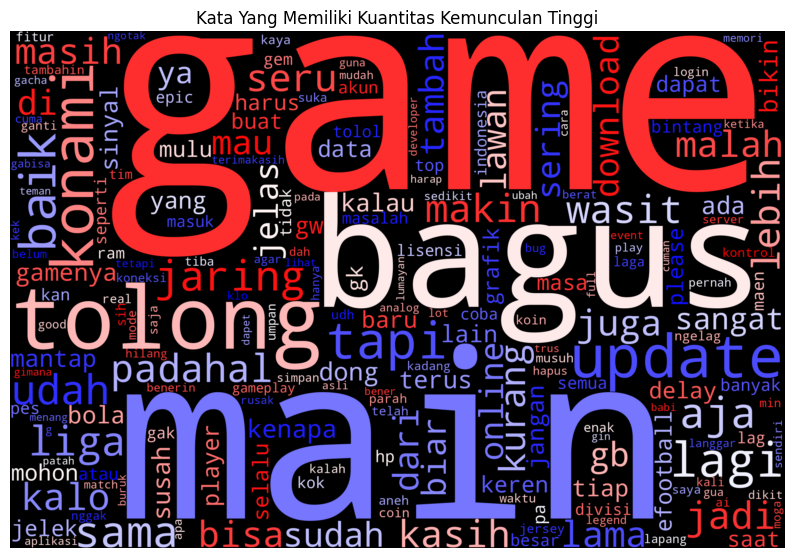

In [37]:
# Visualisasi Kata Yang Memiliki Kuantitas Kemunculan Paling Tinggi

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Kata Yang Memiliki Kuantitas Kemunculan Tinggi')
    plt.axis('off')
    plt.show()

all_words = ' '.join([reviews for reviews in data_final['steamming']])

wordcloud = WordCloud(width=3000,
                      height=2000,
                      random_state=3,
                      background_color='black',
                      colormap='bwr',
                      collocations=False,
                      stopwords=STOPWORDS).generate(all_words)

plot_cloud(wordcloud)

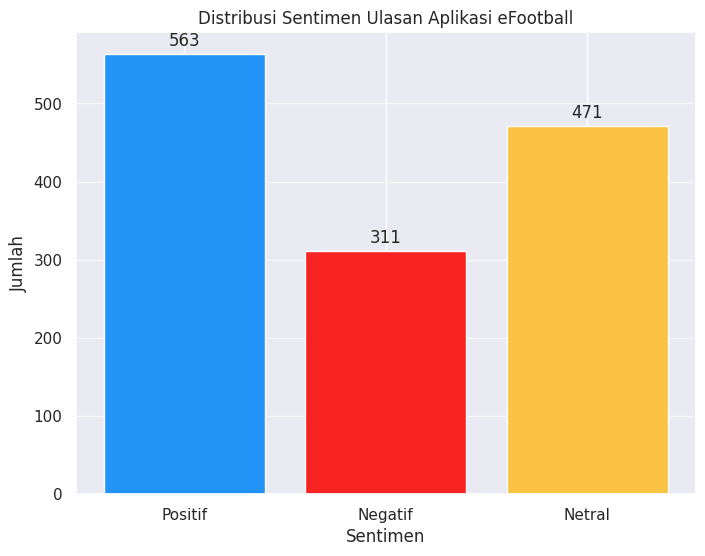

In [38]:
# Visualisasi Distribusi Sentimen Positif , Negatif , Netral Bar Plot

import seaborn as sns

sns.set_theme()

labels = ['Positif', 'Negatif', 'Netral']
counts = [total_positif, total_negatif, total_netral]

def show_bar_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(labels, counts, color=['#2394f7', '#f72323', '#fac343'])

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.grid(axis='y', linestyle='-', alpha=0.7)

    ax.set_xlabel('Sentimen')
    ax.set_ylabel('Jumlah')
    ax.set_title(title)

    plt.show()

show_bar_chart(labels, counts, "Distribusi Sentimen Ulasan Aplikasi eFootball")

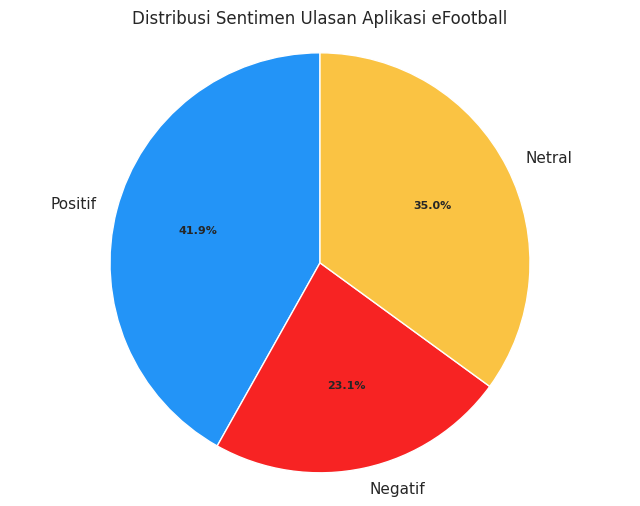

In [39]:
# Visualisasi Distribusi Sentimen Positif , Negatif , Netral Pie Chart

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

labels = ['Positif', 'Negatif', 'Netral']
counts = [total_positif, total_negatif, total_netral]

def show_pie_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Customize colors for each wedge
    colors = ['#2394f7', '#f72323', '#fac343']

    # Create the pie chart
    wedges, texts, autotexts = ax.pie(counts, labels=labels, autopct='%1.1f%%',
                                      startangle=90, colors=colors)

    # Customize the wedge properties
    ax.axis('equal')  # Equal aspect ratio ensures a circular pie chart
    plt.setp(autotexts, size=8, weight='bold')

    # Add a title
    ax.set_title(title)

    plt.show()

# Call the pie chart function
show_pie_chart(labels, counts, "Distribusi Sentimen Ulasan Aplikasi eFootball")

In [40]:
# Menghapus Sentimen Netral

data_final = data_final[data_final['sentimen'] != 'Netral']
data_final

,steamming,steamming_en,sentimen
0,mantap sob,"That's cool, man.",Positif
2,bagus keren,Good. Cool.,Positif
3,good,good,Positif
4,game bagus,Nice game.,Positif
5,turut dapat gemsy sangat bagus,The gemsy helps. Very good.,Positif
...,...,...,...
1339,game baik,"Good game, good game, good game, good game, go...",Positif
1340,suka game tapi tolong konami data jangan besar...,"Love games, but please confirm the data. Don't...",Positif
1341,game jembut,It's a pneumatic game.,Negatif
1343,masak mau update aja harus kosongin ruang gb,cook want update should empty gb space,Negatif


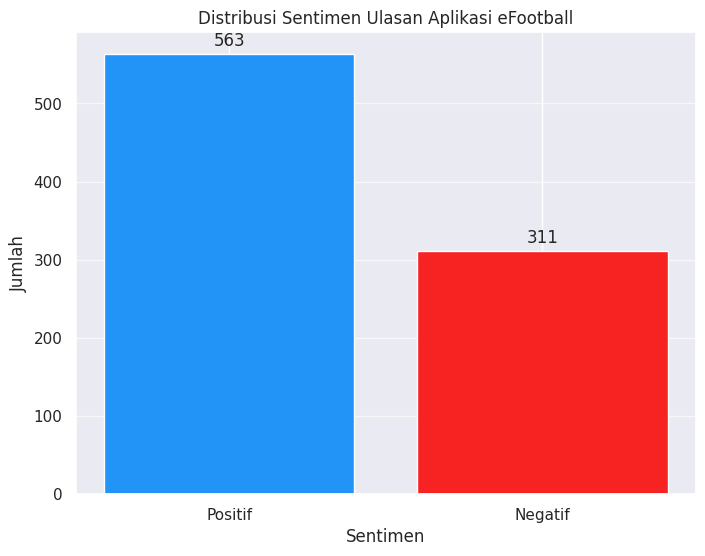

In [41]:
# Visualisasi Distribusi Sentimen Positif & Negatif Bar Plot

import seaborn as sns

sns.set_theme()

labels = ['Positif', 'Negatif']
counts = [total_positif, total_negatif]

def show_bar_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(labels, counts, color=['#2394f7', '#f72323'])

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.grid(axis='y', linestyle='-', alpha=0.7)

    ax.set_xlabel('Sentimen')
    ax.set_ylabel('Jumlah')
    ax.set_title(title)

    plt.show()

show_bar_chart(labels, counts, "Distribusi Sentimen Ulasan Aplikasi eFootball")

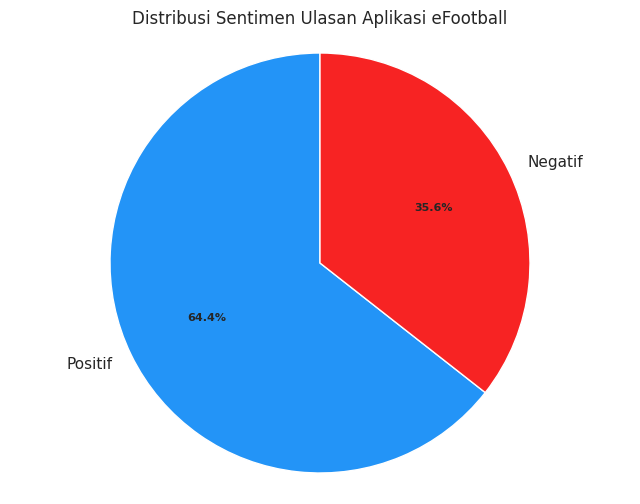

In [42]:
# Visualisasi Distribusi Sentimen Positif & Negatif Bar Pie Chart

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

labels = ['Positif', 'Negatif']
counts = [total_positif, total_negatif]

def show_pie_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Customize colors for each wedge
    colors = ['#2394f7', '#f72323', '#fac343']

    # Create the pie chart
    wedges, texts, autotexts = ax.pie(counts, labels=labels, autopct='%1.1f%%',
                                      startangle=90, colors=colors)

    # Customize the wedge properties
    ax.axis('equal')  # Equal aspect ratio ensures a circular pie chart
    plt.setp(autotexts, size=8, weight='bold')

    # Add a title
    ax.set_title(title)

    plt.show()

# Call the pie chart function
show_pie_chart(labels, counts, "Distribusi Sentimen Ulasan Aplikasi eFootball")

In [43]:
# Replace Data Sentimen

data_final = data_final.replace({'Positif':0, 'Negatif':1})
data_final

,steamming,steamming_en,sentimen
0,mantap sob,"That's cool, man.",0
2,bagus keren,Good. Cool.,0
3,good,good,0
4,game bagus,Nice game.,0
5,turut dapat gemsy sangat bagus,The gemsy helps. Very good.,0
...,...,...,...
1339,game baik,"Good game, good game, good game, good game, go...",0
1340,suka game tapi tolong konami data jangan besar...,"Love games, but please confirm the data. Don't...",0
1341,game jembut,It's a pneumatic game.,1
1343,masak mau update aja harus kosongin ruang gb,cook want update should empty gb space,1


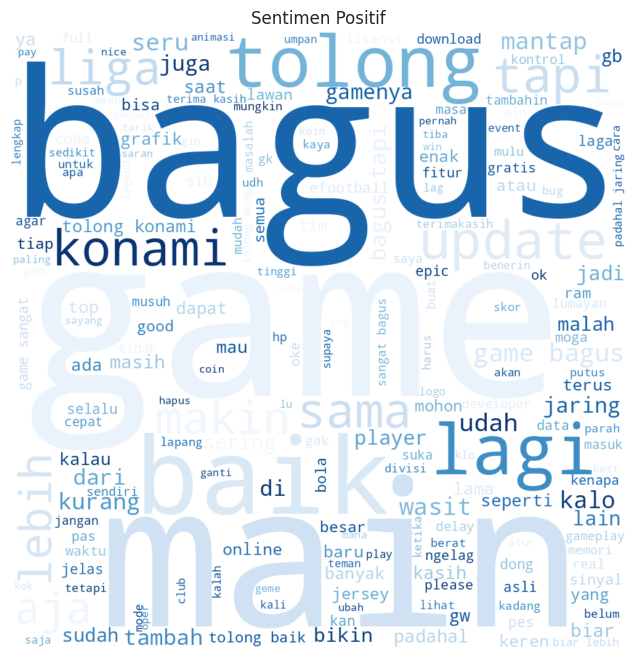

In [44]:
# Visualisasi Wordcould Positif & Negatif

data_positif = data_final[data_final['sentimen'] == 0]
data_negatif = data_final[data_final['sentimen'] == 1]

# Sentimen Positif

all_words = ' '.join([reviews for reviews in data_positif['steamming']])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Positif")
plt.margins(x=0, y=0)
plt.show()

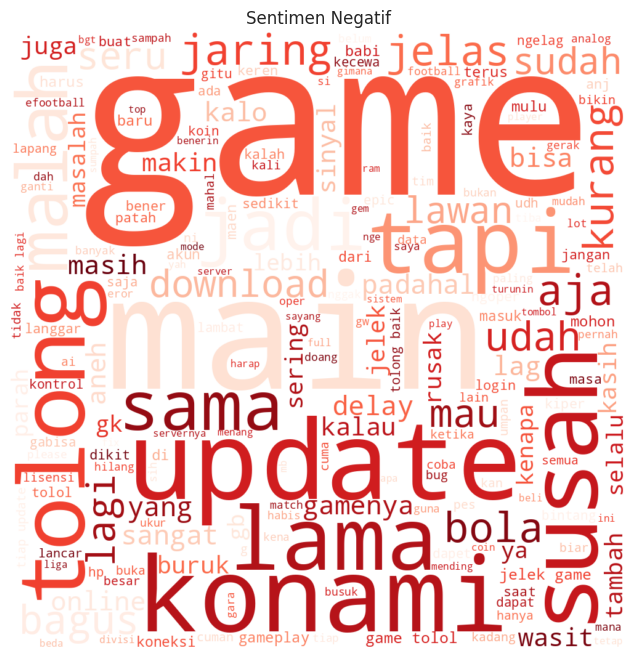

In [45]:
# Sentimen Negatif

all_words = ' '.join([reviews for reviews in data_negatif['steamming']])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Negatif")
plt.margins(x=0, y=0)
plt.show()

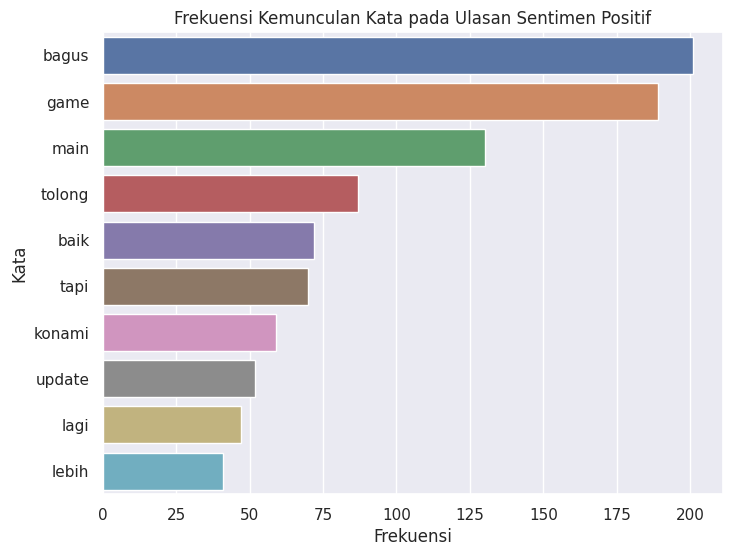

In [46]:
# Frekuensi Kemunculan Kata pada Ulasan Sentimen Positif

# Memfilter ulasan dengan sentimen positif
positive_reviews = data_final[data_final['sentimen'] == 0]['steamming'].tolist()

# Menggunakan CountVectorizer untuk menghitung frekuensi kata
vectorizer = CountVectorizer(stop_words='english')  # Anda bisa menambahkan stop words lainnya jika perlu
word_counts = vectorizer.fit_transform(positive_reviews)
word_frequencies = dict(zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).tolist()[0]))

# Mengubah dictionary menjadi dataframe untuk memudahkan visualisasi
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['kata', 'frekuensi']).sort_values(by='frekuensi', ascending=False)

# Membatasi ke N kata yang paling sering muncul
N = 10
top_words_positive = word_freq_df.head(N)

# Membuat bar plot menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='frekuensi', y='kata', hue='kata', legend=False, data=top_words_positive)
plt.title('Frekuensi Kemunculan Kata pada Ulasan Sentimen Positif')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

In [47]:
# Jumlah detail kata yang sering muncul

print("Jumlah detail kata yang sering muncul pada ulasan sentimen positif : \n")
print(top_words_positive.to_string(index=False))

Jumlah detail kata yang sering muncul pada ulasan sentimen positif : 

  kata  frekuensi
 bagus        201
  game        189
  main        130
tolong         87
  baik         72
  tapi         70
konami         59
update         52
  lagi         47
 lebih         41


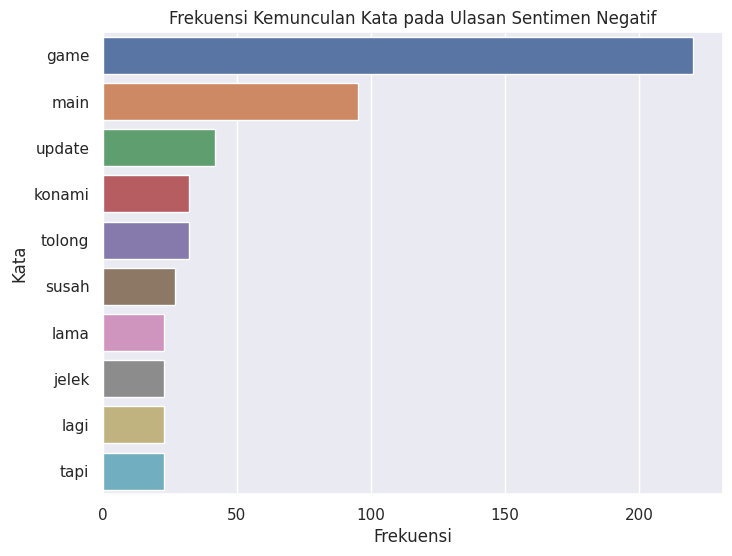

In [48]:
# Frekuensi Kemunculan Kata pada Ulasan Sentimen Negatif

# Memfilter ulasan dengan sentimen positif
negative_reviews = data_final[data_final['sentimen'] == 1]['steamming'].tolist()

# Menggunakan CountVectorizer untuk menghitung frekuensi kata
vectorizer = CountVectorizer(stop_words='english')  # Anda bisa menambahkan stop words lainnya jika perlu
word_counts = vectorizer.fit_transform(negative_reviews)
word_frequencies = dict(zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).tolist()[0]))

# Mengubah dictionary menjadi dataframe untuk memudahkan visualisasi
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['kata', 'frekuensi']).sort_values(by='frekuensi', ascending=False)

# Membatasi ke N kata yang paling sering muncul
N = 10
top_words_negative = word_freq_df.head(N)

# Membuat bar plot menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='frekuensi', y='kata', hue='kata', legend=False, data=top_words_negative)
plt.title('Frekuensi Kemunculan Kata pada Ulasan Sentimen Negatif')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

In [49]:
# Jumlah detail kata yang sering muncul

print("Jumlah detail kata yang sering muncul pada ulasan sentimen Negatif : \n")
print(top_words_negative.to_string(index=False))

Jumlah detail kata yang sering muncul pada ulasan sentimen Negatif : 

  kata  frekuensi
  game        220
  main         95
update         42
konami         32
tolong         32
 susah         27
  lama         23
 jelek         23
  lagi         23
  tapi         23


In [50]:
# Menghitung Jumlah Sentimen Positif, Negatif

data_final['sentimen'].value_counts()

sentimen
0    563
1    311
Name: count, dtype: int64

# **Transormation & Data Preparation**

In [51]:
# Memisahkan data menjadi data latih dan data uji [ Splitting Data ]

X = data_final['steamming']
y = data_final['sentimen']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [52]:
# Menggunakan TF - IDF Vectorizer untuk mengubah teks menjadi fitur numerik [ Text Vectorizer ]

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [53]:
# Melakukan oversampling menggunakan Random Over-Sampling pada data latih

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vec, y_train)

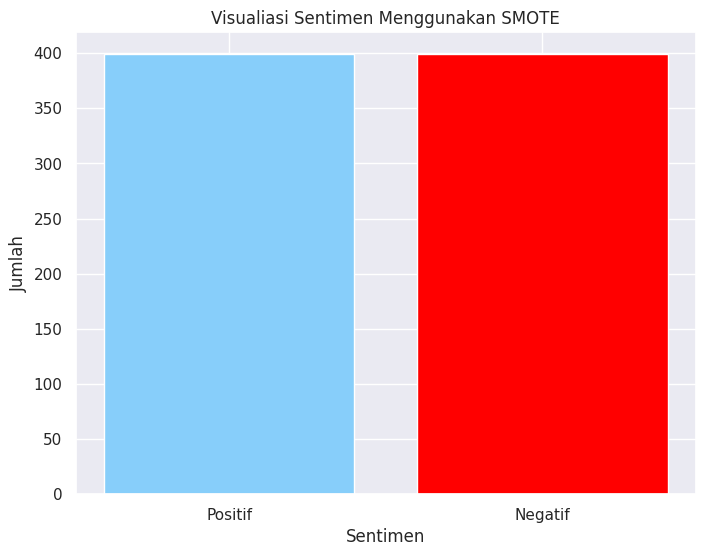

In [54]:
# Visualiasi data hasil resampling menggunakan SMOTE

sentimen_counts = y_train_resampled.value_counts()

plt.figure(figsize = (8, 6))
plt.bar(sentimen_counts.index, sentimen_counts.values, color = ['lightskyblue', 'red'])
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.title('Visualiasi Sentimen Menggunakan SMOTE')
plt.xticks(sentimen_counts.index, ['Positif', 'Negatif'])
plt.show()

# **Data Mining**

In [55]:
# Import Library Warning
import warnings
warnings.filterwarnings('ignore')

In [56]:
# Membangun Model Naive Bayes Classifier

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [57]:
y_pred = naive_bayes.predict(X_test_vec)

# **Interpretation / Evaluation**


1.   Classification Report
2.   Confusion Matrix
3.   Classification Accuracy
4.   Classification Error




In [58]:
# Classification Report

# Evaluasi Model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names = ['Positif', 'Negatif'])

print("Akurasi Model Naive Bayes : ", accuracy)
print("\nLaporan Klasifikasi :\n", classification_rep)

Akurasi Model Naive Bayes :  0.7604562737642585

Laporan Klasifikasi :
               precision    recall  f1-score   support

     Positif       0.80      0.83      0.81       164
     Negatif       0.70      0.65      0.67        99

    accuracy                           0.76       263
   macro avg       0.75      0.74      0.74       263
weighted avg       0.76      0.76      0.76       263



In [59]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives (TP) = ', cm[0, 0])

print('\nTrue Negatives (TN) = ', cm[1, 1])

print('\nFalse Positives (FP) = ', cm[0, 1])

print('\nFalse Negatives (FN) = ', cm[1, 0])



print('\nAccuracy = ', accuracy)

Confusion matrix

 [[136  28]
 [ 35  64]]

True Positives (TP) =  136

True Negatives (TN) =  64

False Positives (FP) =  28

False Negatives (FN) =  35

Accuracy =  0.7604562737642585


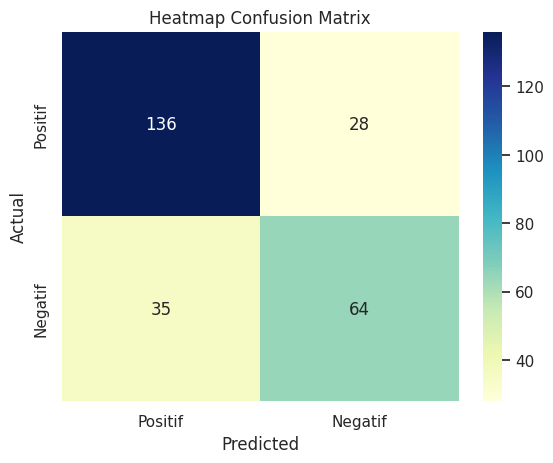

In [60]:
# Visualisasi Heatmap Confusion Matrix

cm_matrix = pd.DataFrame(data=cm, columns=['Positif','Negatif'],
                         index=['Positif','Negatif'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Heatmap Confusion Matrix')
plt.show()

In [61]:
# Slicing Confusion Matrix

TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [62]:
# Classification Accuracy

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.7605


In [63]:
# Classification Error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.2395


# **Testing**

In [64]:
# Contoh teks baru

new_text = input("\nMasukkan Teks Baru : ")
new_text_vec = vectorizer.transform([new_text])
predicted_sentimen = naive_bayes.predict(new_text_vec)
predicted_proba = naive_bayes.predict_proba(new_text_vec)

if predicted_sentimen[0] == 0:
    sentimen_label = "Positif"
    probability = predicted_proba[0][0] * 100
elif predicted_sentimen[0] == 1:
    sentimen_label = "Negatif"
    probability = predicted_proba[0][1] * 100

print("Hasil Analisis Sentimen Untuk Teks Baru:", sentimen_label)
print("Probabilitas: {:.2f}%".format(probability))
print("Probabilitas:", probability, "%")


Masukkan Teks Baru : Pemiliharaan server yang lama malah tak memperbaiki kualitas permainan, game masih sering terputus karena koneksi padahal memakai WiFi akibatnya tingkat kesantunan saya menurun,analog yang berat dan terlambat, dan suara komentator yang delay. Semoga kendali ini cepat diperbaiki terutama pada analog yg berat yg tak sesuai arah tangan
Hasil Analisis Sentimen Untuk Teks Baru: Negatif
Probabilitas: 68.96%
Probabilitas: 68.96383178965921 %


In [65]:
# Contoh teks baru

new_text = input("\nMasukkan Teks Baru : ")
new_text_vec = vectorizer.transform([new_text])
predicted_sentimen = naive_bayes.predict(new_text_vec)
predicted_proba = naive_bayes.predict_proba(new_text_vec)

if predicted_sentimen[0] == 0:
    sentimen_label = "Positif"
    probability = predicted_proba[0][0] * 100
elif predicted_sentimen[0] == 1:
    sentimen_label = "Negatif"
    probability = predicted_proba[0][1] * 100

print("Hasil Analisis Sentimen Untuk Teks Baru:", sentimen_label)
print("Probabilitas: {:.2f}%".format(probability))
print("Probabilitas:", probability, "%")



Masukkan Teks Baru : Ini game nya gua rating 5, karena game nya udah bagus grafik nya lumayan oke. Dan satu harus diperbaiki kalo lawan nya bot itu sinyal nya aman Aman aja,terus kalo ketemu lawan asli parah itu ngelag nya padahal jaringan nya bagus dan tidak lelet. Mohon diperbaiki yah 🙏🙏
Hasil Analisis Sentimen Untuk Teks Baru: Positif
Probabilitas: 57.84%
Probabilitas: 57.84473897147466 %


In [66]:
# Contoh teks baru

new_text = input("\nMasukkan Teks Baru : ")
new_text_vec = vectorizer.transform([new_text])
predicted_sentimen = naive_bayes.predict(new_text_vec)
predicted_proba = naive_bayes.predict_proba(new_text_vec)

if predicted_sentimen[0] == 0:
    sentimen_label = "Positif"
    probability = predicted_proba[0][0] * 100
elif predicted_sentimen[0] == 1:
    sentimen_label = "Negatif"
    probability = predicted_proba[0][1] * 100

print("Hasil Analisis Sentimen Untuk Teks Baru:", sentimen_label)
print("Probabilitas: {:.2f}%".format(probability))
print("Probabilitas:", probability, "%")



Masukkan Teks Baru : Ini pertama kali nya aku nyentuh eFootball setelah lama mainin FC Mobile. Jujur, GAME INI SERU PAKE BANGETT, event-event nya bervariatif banget dan nggak bikin bosen buat dimainin terus menerus. So far jg gak nemuin bug sedikitpun dari game ini, nyaris sempurna buat ini game. Kuharap game ini bisa berkembang lebih baik lagi kedepan nya!
Hasil Analisis Sentimen Untuk Teks Baru: Positif
Probabilitas: 61.95%
Probabilitas: 61.94605759087928 %
